# Init

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import array
import glob

In [2]:
# initialisation at startup
initial_lane_search = True

# Compute Camera Calibration

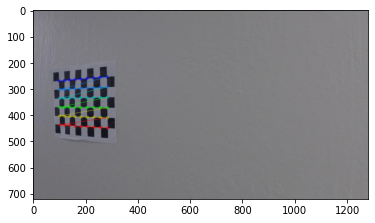

In [3]:
# prepare object points
# number of inside corners in x and y
ny = 6 
nx = 9

# Make a list of calibration images (calibration1..20)
images_cal = glob.glob('camera_cal/calibration*.jpg', recursive=False)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# create objp
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# get chessboard corners for all calibration images
for fname in images_cal:
    img_cal = plt.imread(fname)

    # Convert to grayscale
    gray_cal = cv2.cvtColor(img_cal, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_cal, (nx, ny), None)

    # If corners found, draw corners
    if ret == True:
        objpoints.append(objp)
#         corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)
    
        # draw & display corners
        cv2.drawChessboardCorners(img_cal, (nx, ny), corners, ret)
        plt.imshow(img_cal)

In [4]:
# calibrate camera
ret, mtx, dist, rvecs, tvecs  = cv2.calibrateCamera(objpoints, imgpoints, img_cal.shape[1:], None,None)

# # undistort test image
# img_undist = cv2.undistort(img_cal, mtx, dist, None, mtx)
# plt.imshow(img_undist)

# Apply distortion correction

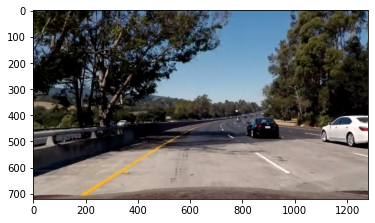

In [5]:
# load input image
img_input = plt.imread('test_images/test5.jpg')

# undistort camera images
img_undist = cv2.undistort(img_input, mtx, dist, None, mtx)
plt.imshow(img_undist)

# Generate thesholded binary image (color transform, gradients etc...)

In [6]:
# define functions

def extract_single_color(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    return s_channel

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = extract_single_color(image)
    if orient == 'x':
        sobel_orient = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel_orient = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel_orient)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)        
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 255 #imshow accepts 1 not!
    return grad_binary

def abs_magn_thresh(image, magn_sobel_kernel=3, thresh_2=(0, 255)):
    # Calculate gradient magnitude
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = extract_single_color(image)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=magn_sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=magn_sobel_kernel)
#     magn = np.sqrt(sobel_x * sobel_x + sobel_y * sobel_y)
    magn = np.sqrt(np.power(sobel_x,2) + np.power(sobel_y,2))
    scaled_magn = np.uint8(255*magn/np.max(magn))
    # Apply threshold
    magn_binary = np.zeros_like(scaled_magn)       
    magn_binary[(scaled_magn > (thresh_2[0])) & (scaled_magn < thresh_2[1])] = 255
    return magn_binary

def abs_dir_threshold(image, dir_sobel_kernel=3, dir_thresh=(-np.pi/2, np.pi/2)):
    # Calculate gradient direction
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = extract_single_color(image)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=dir_sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=dir_sobel_kernel)
    abs_grad_x = np.absolute(sobel_x)
    abs_grad_y = np.absolute(sobel_y)
    direction_grad = np.arctan2(abs_grad_y, abs_grad_x)
    # Apply threshold
    dir_binary = np.zeros_like(direction_grad)
    dir_binary[(direction_grad > dir_thresh[0]) & (direction_grad < dir_thresh[1])] = 1
    return dir_binary

def abs_average(binary_image, filter_size=3):
    output_image = cv2.blur(binary_image, (filter_size, filter_size))       
#         output_image = cv2.medianBlur(binary_image, filter_size)
    return output_image

def abs_threshold(image, threshold):
    binary_image = np.zeros_like(image)
    binary_image[image > threshold/255] = 255
    return binary_image

True

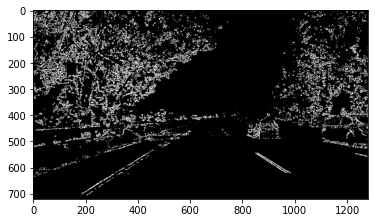

In [7]:
# filter parameters
_sobelx_low = 16
_sobelx_high = 255
_sobelx_filter = 3

_sobely_low = 36
_sobely_high = 255
_sobely_filter = 3

_magn_low = 15
_magn_high = 255
_magn_filter = 3

_direction_low = 229
_direction_high = 287
_direction_filter = 15
_direction_avg_filter = 11
_direction_thresh = 143

# use functions to generate binary image
_sobelx_binary = abs_sobel_thresh(img_undist, 'x', _sobelx_filter, (_sobelx_low, _sobelx_high))
_sobely_binary = abs_sobel_thresh(img_undist, 'y', _sobely_filter, (_sobely_low, _sobely_high))
_mag_binary = abs_magn_thresh(img_undist, _magn_filter, (_magn_low, _magn_high))
_dir_binary = abs_dir_threshold(img_undist, _direction_filter, (_direction_low, _direction_high))
_avg_img = abs_average(_dir_binary, _direction_avg_filter)
_thres_img = abs_threshold(_avg_img, _direction_thresh)
combined_binary = np.zeros_like(_sobelx_binary)
combined_binary[((_sobelx_binary == 255) & (_sobely_binary == 255)) | ((_mag_binary == 255) & (_thres_img == 255))] = 255

plt.imshow(combined_binary, cmap='gray')
cv2.imwrite("output_images/combined_binary.jpg", combined_binary)

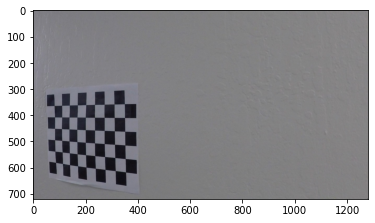

In [8]:
image_cal = plt.imread(images_cal[10])
plt.imshow(image_cal)

# Apply a perspective transform to rectify binary image (bird-eye view)

True

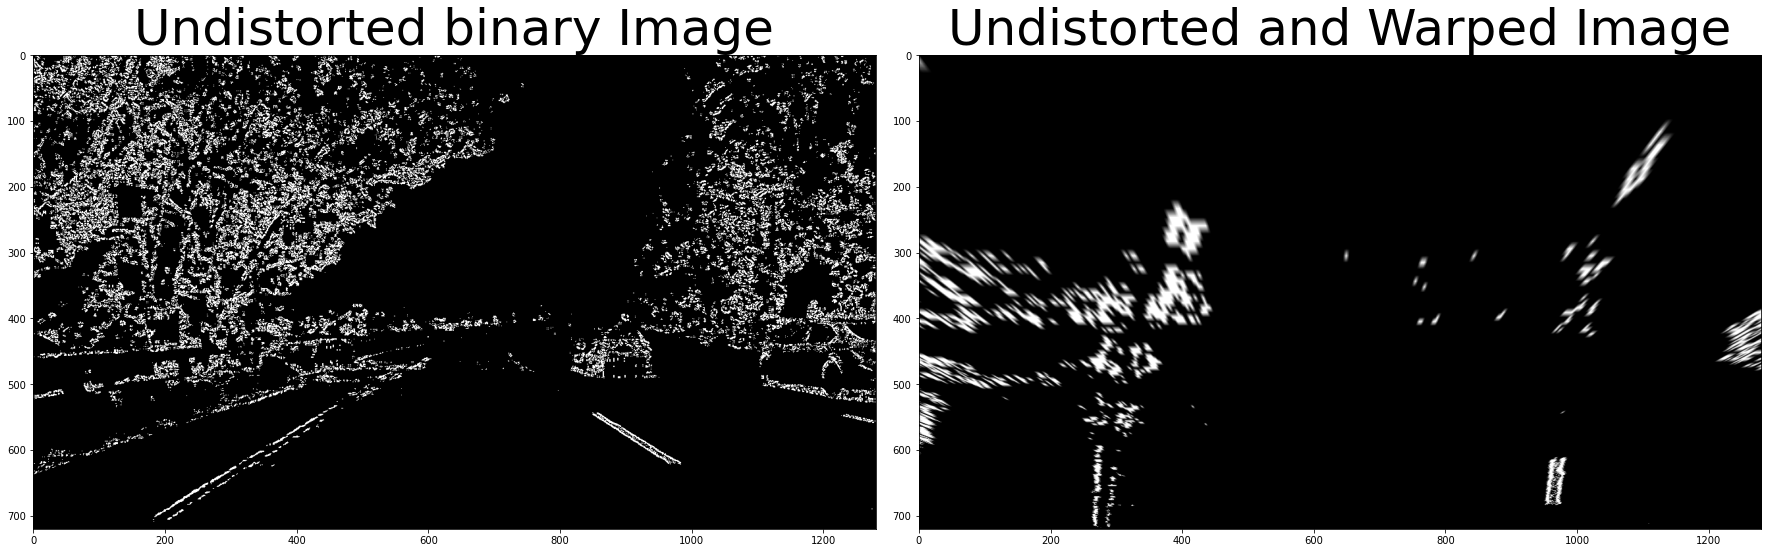

In [9]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
#     # Pass in your image into this function
#     # Write code to do the following steps
#     # 1) Undistort using mtx and dist
#     dst_img = cv2.undistort(img, mtx, dist, None, mtx)
#     # 2) Convert to grayscale
#     dst_gray = cv2.cvtColor(dst_img, cv2.COLOR_RGB2GRAY)
#     # 3) Find the chessboard corners
#     ret, corners = cv2.findChessboardCorners(dst_gray, (nx,ny), None)
#     # 4) If corners found: 

# #     if ret == True:
#     # a) draw corners
#     dst_corners = cv2.drawChessboardCorners(dst_img, (nx, ny), corners, ret)
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
         #Note: you could pick any four of the detected corners 
         # as long as those four corners define a rectangle
         #One especially smart way to do this would be to use four well-chosen
         # corners that were automatically detected during the undistortion steps
         #We recommend using the automatic detection of corners in your code
#     src = np.float32([[corners[0][0][0],corners[0][0][1]],[corners[nx-1][0][0],corners[nx-1][0][1]],[corners[nx*(ny-1)][0][0],corners[nx*(ny-1)][0][1]],[corners[nx*ny-1][0][0],corners[nx*ny-1][0][1]]])
    src = np.float32([[200,img.shape[0]],[597,447],[686,447],[1124,img.shape[0]]])
#     src = np.float32([[177,img.shape[0]],[595,447],[685,447],[1124,img.shape[0]]])
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
#     dx = dst_img.shape[1]/(nx+1)*nx
#     dy = dst_img.shape[0]/(nx+1)*nx
#     x = dst_img.shape[1]/(nx+1)/2
#     y = dst_img.shape[0]/(nx+1)/2
#     dst = np.float32([[x,y],[x+dx,y],[x,y+dy],[x+dx,y+dy]])
#     dst = np.float32([[0,img.shape[0]],[0,0],[img.shape[1],0],[img.shape[1],img.shape[0]]])
    dst = np.float32([[300,img.shape[0]],[300,0],[950,0],[950,img.shape[0]]])
#     dst = np.float32([[177,img.shape[0]],[177,0],[1124,0],[1124,img.shape[0]]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M =  cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    #delete the next two lines
    # M = None
    # warped = np.copy(transformed_dst) 
#     draw_line(warped, 312,img_undist.shape[0], 312,0, [255, 255, 255], 3)
#     draw_line(warped, 940,img_undist.shape[0], 940,0, [255, 255, 255], 3)
    
    return warped, M, Minv

def draw_line(img, x1, y1, x2, y2, color=[255, 0, 0], thickness=3):
    return cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# draw lines for correction
# draw_line(img_undist, 200,img_undist.shape[0], 597,447,thickness=1)
# draw_line(img_undist, 685,447, 1124,img_undist.shape[0],thickness=1)

binary_warped, perspective_M, perspective_Minv = corners_unwarp(combined_binary, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistorted binary Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/binary_warped.jpg", binary_warped)

# Detect lane pixels and fit to find the lane boundary.

In [10]:
# function def's
# search lanes from scratch
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    img_lanes = np.copy(out_img) # copy output_image for selected visualization
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window 
        # (`right` or `leftx_current`) on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, img_lanes


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, img_lanes = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` #
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    img_lanes[lefty, leftx] = [255, 0, 0]
    img_lanes[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, img_lanes, left_fit, right_fit, left_fitx, right_fitx, ploty

In [11]:
# use Polynomial fit values from the previous frame
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() #
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit #
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit


def search_around_poly(binary_warped, left_fit_last, right_fit_last):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox >= (left_fit_last[0]*(nonzeroy**2) + left_fit_last[1]*nonzeroy + left_fit_last[2] - margin)) & 
                    (nonzerox < (left_fit_last[0]*(nonzeroy**2) + left_fit_last[1]*nonzeroy + left_fit_last[2] + margin)))
    right_lane_inds = ((nonzerox >= (right_fit_last[0]*(nonzeroy**2) + right_fit_last[1]*nonzeroy +  right_fit_last[2] - margin)) & 
                    (nonzerox < (right_fit_last[0]*(nonzeroy**2) + right_fit_last[1]*nonzeroy + right_fit_last[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit_new, right_fit_new = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    
    return result, out_img, left_fit_new, right_fit_new, left_fitx, right_fitx, ploty

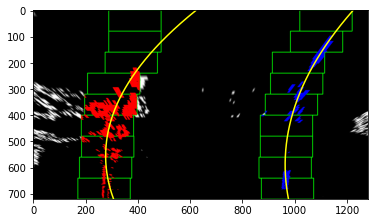

In [12]:
# check if prior exists, or if we have to search lane from scratch
# TODO: add case for reset if search from prior does not work

if initial_lane_search:
    initial_lane_search = False
    # searching lane lines from scratch (sliding window) for startup and fallback
    img_fittet_lanes, lanes, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
else:
    # searching lane lines from prior 
    img_fittet_lanes, lanes, left_fit, right_fit, left_fitx, right_fitx, ploty = search_around_poly(binary_warped, left_fit, right_fit)
plt.imshow(img_fittet_lanes)

# Determine the curvature of the lane and vehicle position with respect to center.

In [13]:
def measure_curvature_real(y_eval, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/63 # 63(53-69)pixel; meters per pixel in y dimension
    xm_per_pix = 3.7/611 # 611(605-620)pixel; meters per pixel in x dimension
    
    
    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2)/(np.absolute(2*left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2)/(np.absolute(2*right_fit_cr[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(img_fittet_lanes.shape[0], left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

1617.678710343236 m 1467.150284438144 m


# Warp the detected lane boundaries back onto the original image.

True

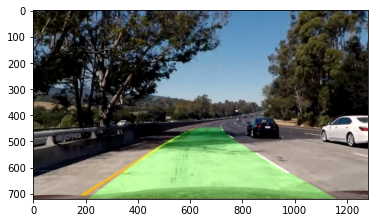

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
rewarp_annotated = cv2.warpPerspective(color_warp, perspective_Minv, (img_fittet_lanes.shape[1], img_fittet_lanes.shape[0])) 

# Combine the result with the original image
result_lane = cv2.addWeighted(img_undist, 1, rewarp_annotated, 0.3, 0)

plt.imshow(result_lane)

result_bgr = cv2.cvtColor(result_lane, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/result.jpg", result_bgr)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

True

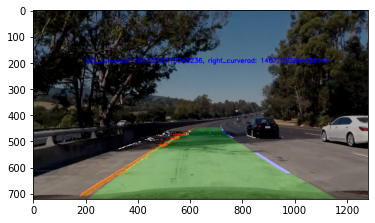

In [15]:
rewarp_lane_markings = cv2.warpPerspective(lanes, perspective_Minv, (img_fittet_lanes.shape[1], img_fittet_lanes.shape[0])) 
result_annotated = cv2.addWeighted(result_lane, 0.7, rewarp_lane_markings, 1, 0)

text_curvature = f"left_curverad: {left_curverad}, right_curverad: {right_curverad}"
x = 200
y = 200
font = cv2.FONT_HERSHEY_SIMPLEX 
fontscale = 0.8
color = (0, 0, 255) 
thickness = 2

cv2.putText(result_annotated, text_curvature,(x,y),font,fontscale,color,thickness)
result_annotated_bgr = cv2.cvtColor(result_annotated, cv2.COLOR_RGB2BGR)

plt.imshow(result_annotated)
cv2.imwrite("output_images/result_2.jpg", result_annotated_bgr)

In [16]:
# TODO: All the bonus steps mentioned in Tips and tricks and project rubric
# (e.g. offset, tracking, sanity check, look-ahead filter, reset, smoothing)